In [1]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing libraries for machine learning
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.utils.class_weight import compute_class_weight
from joblib import dump,load
import shap

# Display setting for exploration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Check out if the environment is the correct Anaconda one
import sys
print('environment: ',sys.executable)

# Set up directory to be the github repository
# requires git
import os
import subprocess
os.getcwd()
output = subprocess.check_output(['git', 'rev-parse', '--show-toplevel'])
path = output.decode('utf-8').strip()
print('working directory: ',path)
os.chdir(path)


environment:  c:\Users\ricca\Documents\Codice\Anaconda\envs\Thesis\python.exe
working directory:  C:/Users/ricca/Documents/Codice/Uni/Thesis-SEM-ML


In [3]:
from Source.DataPreparation.DataProcessor import DataProcessor
from Source.Classification.observed_variables_classification import GBoostClassification, LogisticRegressionClass

In [4]:
Results_XGB_dict = {
    'eng_timeflies': [],
    'eng_enthusiastic': [],
    'eng_energy': []
}

Results_LR_dict = {
    'eng_timeflies': [],
    'eng_enthusiastic': [],
    'eng_energy': []
}

Results_Random_dict = {
    'eng_timeflies': [],
    'eng_enthusiastic': [],
    'eng_energy': []
}

Results_Majority_dict = {
    'eng_timeflies': [],
    'eng_enthusiastic': [],
    'eng_energy': []
}

Results_XGB_Proba_dict = {
    'eng_timeflies': [],
    'eng_enthusiastic': [],
    'eng_energy': []
}


In [5]:
montecarloiter=10

for i in range(montecarloiter):
    print(f"Starting the iteration n.{i+1}")
    processorclass=DataProcessor()
    processorclass.read_df()
    processorclass.split_data(test_size=0.3)
    processorclass.save_data()
    try:
        processorclass.process_CFA()
    except Exception as e:
        print(f"Error during process_CFA for iteration n.{i+1}: {e}")
        continue    

    for dimension in ['eng_timeflies', 'eng_enthusiastic', 'eng_energy']:
        print(f"Starting the iteration n.{i+1} for dimension {dimension}")

        X_train,y_train,X_test,y_test = processorclass.train_test_data_for_WEtarget(target_variable=dimension,combineseldom=True)

         # Calculate random and majority classifier accuracy
        class_counts = np.bincount(y_test)
        class_probabilities = class_counts / len(y_test)
        random_accuracy = np.sum(class_probabilities**2)
        Results_Random_dict[dimension].append(random_accuracy)
        print(f"Accuracy of a random classifier for dimension {dimension}: {random_accuracy:.4f}")
        majority_class = np.argmax(class_counts)
        majority_accuracy = class_counts[majority_class] / len(y_test)
        Results_Majority_dict[dimension].append(majority_accuracy)
        print(f"Accuracy of a majority classifier for dimension {dimension}: {majority_accuracy:.4f}")


        # XGBClassifier
        Xgboost=GBoostClassification(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
        Xgboost.train(verbosity=0,n_iter=50)
        mxgbresults = Xgboost.get_results()
        Results_XGB_dict[dimension].append((mxgbresults['accuracy'],mxgbresults['precision'],mxgbresults['recall'],mxgbresults['train_accuracy'],mxgbresults['train_precision'],mxgbresults['train_recall']))
        Results_XGB_Proba_dict[dimension].append(Xgboost.get_probas())
        print(f"Iteration {i+1} XGBoost: accuracy: {mxgbresults['accuracy']}, precision: {mxgbresults['precision']}, recall: {mxgbresults['recall']}, train_accuracy:{mxgbresults['train_accuracy']}")

        # Logistic Regression
        LRcla= LogisticRegressionClass(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
        LRcla.median_imputation()
        LRcla.train(verbosity=0)
        LRresults = LRcla.get_results()
        Results_LR_dict[dimension].append((LRresults['accuracy'],LRresults['precision'],LRresults['recall'],LRresults['train_accuracy'],LRresults['train_precision'],LRresults['train_recall']))

        print(f"Iteration {i+1} Logistic: accuracy: {LRresults['accuracy']}, precision: {LRresults['precision']}, recall: {LRresults['recall']}, train_accuracy:{LRresults['train_accuracy']}")

        print(("-------------------------------------------------"))

Starting the iteration n.1
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA
Starting the iteration n.1 for dimension eng_timeflies
Values of the classes 1 and 2 were combined.
Accuracy of a random classifier for dimension eng_timeflies: 0.3101
Accuracy of a majority classifier for dimension eng_timeflies: 0.3994
Starting the XGBClassifier training
Iteration 1 XGBoost: accuracy: 0.441340782122905, precision: 0.40114244022290524, recall: 0.441340782122905, train_accuracy:0.60431654676259
Starting the Logistic Regression
Iteration 1 Logistic: accuracy: 0.4720670391061452, precision: 0.4427328596172072, recall: 0.4720670391061452, train_accuracy:0.5275779376498801
-------------------------------------------------
Starting the iteration n.1 for dimension eng_enthusiastic
Values of the classes 1 and 2 were combined.
Accuracy of a random classifier for dimension eng_enthusiastic: 0.3096
Accuracy of a majority classifier for

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


Iteration 4 XGBoost: accuracy: 0.4972067039106145, precision: 0.5047393138560998, recall: 0.4972067039106145, train_accuracy:0.5203836930455635
Starting the Logistic Regression
Iteration 4 Logistic: accuracy: 0.4972067039106145, precision: 0.5000398558302079, recall: 0.4972067039106145, train_accuracy:0.5143884892086331
-------------------------------------------------
Starting the iteration n.4 for dimension eng_enthusiastic
Values of the classes 1 and 2 were combined.
Accuracy of a random classifier for dimension eng_enthusiastic: 0.3205
Accuracy of a majority classifier for dimension eng_enthusiastic: 0.4385
Starting the XGBClassifier training
Iteration 4 XGBoost: accuracy: 0.5363128491620112, precision: 0.5254355093138343, recall: 0.5363128491620112, train_accuracy:0.7302158273381295
Starting the Logistic Regression
Iteration 4 Logistic: accuracy: 0.5418994413407822, precision: 0.5267317821207954, recall: 0.5418994413407822, train_accuracy:0.592326139088729
------------------------

The objective has been evaluated at this point before.


Iteration 7 XGBoost: accuracy: 0.44972067039106145, precision: 0.4149441164515569, recall: 0.44972067039106145, train_accuracy:0.5587529976019184
Starting the Logistic Regression
Iteration 7 Logistic: accuracy: 0.42178770949720673, precision: 0.5050044681496801, recall: 0.42178770949720673, train_accuracy:0.5287769784172662
-------------------------------------------------
Starting the iteration n.7 for dimension eng_enthusiastic
Values of the classes 1 and 2 were combined.
Accuracy of a random classifier for dimension eng_enthusiastic: 0.2990
Accuracy of a majority classifier for dimension eng_enthusiastic: 0.3939
Starting the XGBClassifier training
Iteration 7 XGBoost: accuracy: 0.5418994413407822, precision: 0.550048885109659, recall: 0.5418994413407822, train_accuracy:0.8129496402877698
Starting the Logistic Regression
Iteration 7 Logistic: accuracy: 0.5251396648044693, precision: 0.5276581461514094, recall: 0.5251396648044693, train_accuracy:0.6247002398081535
--------------------

In [6]:
def compute_95_CI(results):
    std_error = np.std(results) / np.sqrt(len(results))
    ci_upper = np.mean(results) + 1.96 * std_error
    ci_lower = np.mean(results) - 1.96 * std_error
    return ci_lower, ci_upper



def print_avg_metrics(Results, model_name, dimension):
    accuracy_avg = np.mean([res[0] for res in Results[dimension]])
    precision_avg = np.mean([res[1] for res in Results[dimension]])
    recall_avg = np.mean([res[2] for res in Results[dimension]])
    train_accuracy_avg = np.mean([res[3] for res in Results[dimension]])
    train_precision_avg = np.mean([res[4] for res in Results[dimension]])
    train_recall_avg = np.mean([res[5] for res in Results[dimension]])
    # Calculate CIs
    accuracy_ci = compute_95_CI([res[0] for res in Results[dimension]])
    precision_ci = compute_95_CI([res[1] for res in Results[dimension]])
    recall_ci = compute_95_CI([res[2] for res in Results[dimension]])
    train_accuracy_ci = compute_95_CI([res[3] for res in Results[dimension]])
    train_precision_ci = compute_95_CI([res[4] for res in Results[dimension]])
    
    print(f"Model: {model_name} for dimension: {dimension}")
    print(f"Average Accuracy over {montecarloiter} iterations: {accuracy_avg:.2f} (95% CI: {accuracy_ci[0]:.2f} - {accuracy_ci[1]:.2f})")
    print(f"Average Precision over {montecarloiter} iterations: {precision_avg:.2f} (95% CI: {precision_ci[0]:.2f} - {precision_ci[1]:.2f})")
    print(f"Average Recall over {montecarloiter} iterations: {recall_avg:.2f} (95% CI: {recall_ci[0]:.2f} - {recall_ci[1]:.2f})")
    print(f"Average Training Accuracy over {montecarloiter} iterations: {train_accuracy_avg:.2f} (95% CI: {train_accuracy_ci[0]:.2f} - {train_accuracy_ci[1]:.2f})")
    print(f"Average Training Precision over {montecarloiter} iterations: {train_precision_avg:.2f} (95% CI: {train_precision_ci[0]:.2f} - {train_precision_ci[1]:.2f})")
    print("-------------------------------------------------")





for dimension in ['eng_timeflies', 'eng_enthusiastic', 'eng_energy']:
    Random_accuracy_avg = np.mean(Results_Random_dict[dimension])
    Majority_accuracy_avg = np.mean(Results_Majority_dict[dimension])
    # Calculate CIs
    Random_accuracy_ci = compute_95_CI(Results_Random_dict[dimension])
    Majority_accuracy_ci = compute_95_CI(Results_Majority_dict[dimension])

    print(f"Random classifier for dimension: \"{dimension}\". Average Accuracy over {montecarloiter} iterations: {Random_accuracy_avg:.2f} (95% CI: {Random_accuracy_ci[0]:.2f} - {Random_accuracy_ci[1]:.2f})")
    print(f"Majority classifier for dimension: \"{dimension}\". Average Accuracy over {montecarloiter} iterations: {Majority_accuracy_avg:.2f} (95% CI: {Majority_accuracy_ci[0]:.2f} - {Majority_accuracy_ci[1]:.2f})")

Random classifier for dimension: "eng_timeflies". Average Accuracy over 10 iterations: 0.32 (95% CI: 0.32 - 0.33)
Majority classifier for dimension: "eng_timeflies". Average Accuracy over 10 iterations: 0.42 (95% CI: 0.41 - 0.43)
Random classifier for dimension: "eng_enthusiastic". Average Accuracy over 10 iterations: 0.31 (95% CI: 0.30 - 0.32)
Majority classifier for dimension: "eng_enthusiastic". Average Accuracy over 10 iterations: 0.41 (95% CI: 0.40 - 0.42)
Random classifier for dimension: "eng_energy". Average Accuracy over 10 iterations: 0.32 (95% CI: 0.32 - 0.33)
Majority classifier for dimension: "eng_energy". Average Accuracy over 10 iterations: 0.47 (95% CI: 0.46 - 0.47)


In [7]:
for dimension in ['eng_timeflies', 'eng_enthusiastic', 'eng_energy']:
    print_avg_metrics(Results_XGB_dict, "XGBoost", dimension)

Model: XGBoost for dimension: eng_timeflies
Average Accuracy over 10 iterations: 0.47 (95% CI: 0.45 - 0.48)
Average Precision over 10 iterations: 0.45 (95% CI: 0.43 - 0.47)
Average Recall over 10 iterations: 0.47 (95% CI: 0.45 - 0.48)
Average Training Accuracy over 10 iterations: 0.60 (95% CI: 0.55 - 0.65)
Average Training Precision over 10 iterations: 0.64 (95% CI: 0.59 - 0.70)
-------------------------------------------------
Model: XGBoost for dimension: eng_enthusiastic
Average Accuracy over 10 iterations: 0.54 (95% CI: 0.54 - 0.55)
Average Precision over 10 iterations: 0.55 (95% CI: 0.53 - 0.57)
Average Recall over 10 iterations: 0.54 (95% CI: 0.54 - 0.55)
Average Training Accuracy over 10 iterations: 0.77 (95% CI: 0.70 - 0.83)
Average Training Precision over 10 iterations: 0.78 (95% CI: 0.72 - 0.84)
-------------------------------------------------
Model: XGBoost for dimension: eng_energy
Average Accuracy over 10 iterations: 0.53 (95% CI: 0.51 - 0.54)
Average Precision over 10 it

In [8]:
for dimension in ['eng_timeflies', 'eng_enthusiastic', 'eng_energy']:
    print_avg_metrics(Results_LR_dict, "Logistic Regression", dimension)

Model: Logistic Regression for dimension: eng_timeflies
Average Accuracy over 10 iterations: 0.46 (95% CI: 0.45 - 0.48)
Average Precision over 10 iterations: 0.45 (95% CI: 0.44 - 0.47)
Average Recall over 10 iterations: 0.46 (95% CI: 0.45 - 0.48)
Average Training Accuracy over 10 iterations: 0.52 (95% CI: 0.51 - 0.53)
Average Training Precision over 10 iterations: 0.54 (95% CI: 0.53 - 0.55)
-------------------------------------------------
Model: Logistic Regression for dimension: eng_enthusiastic
Average Accuracy over 10 iterations: 0.54 (95% CI: 0.52 - 0.55)
Average Precision over 10 iterations: 0.53 (95% CI: 0.51 - 0.54)
Average Recall over 10 iterations: 0.54 (95% CI: 0.52 - 0.55)
Average Training Accuracy over 10 iterations: 0.60 (95% CI: 0.59 - 0.61)
Average Training Precision over 10 iterations: 0.60 (95% CI: 0.60 - 0.61)
-------------------------------------------------
Model: Logistic Regression for dimension: eng_energy
Average Accuracy over 10 iterations: 0.52 (95% CI: 0.51 

In [9]:
## Example data
#unique_classes = np.unique(Xgboost.y_test)
#y_test = Xgboost.y_test
#y_pred_prob = Xgboost.get_probas()  # Assuming you have the predicted probabilities
#
## Binarize the output (i.e., create a one-hot encoded matrix)
#y_test_bin = label_binarize(y_test, classes=unique_classes)
#n_classes = y_test_bin.shape[1]
#
## Compute ROC curve and ROC area for each class
#fpr = dict()
#tpr = dict()
#roc_auc = dict()
#for i in range(n_classes):
#    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
#    roc_auc[i] = auc(fpr[i], tpr[i])
#
## Print the AUC for each class
#for i, class_name in enumerate(unique_classes):
#    print(f"AUC for class {class_name}: {roc_auc[i]}")
#
## Print classification report
#y_pred = Xgboost.y_pred
#print(classification_report(y_test, y_pred))

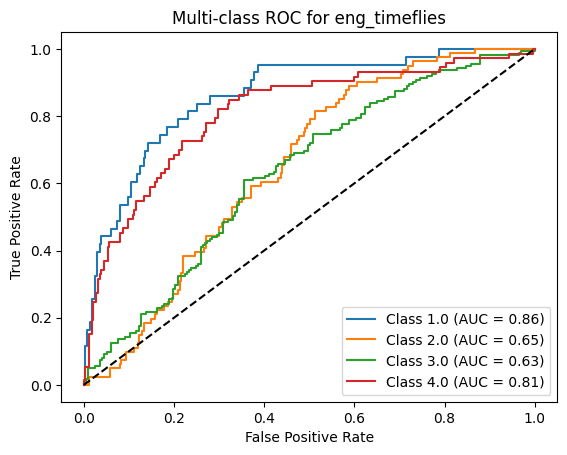

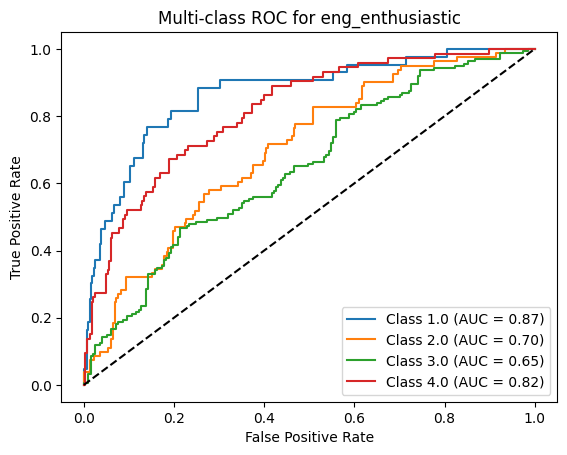

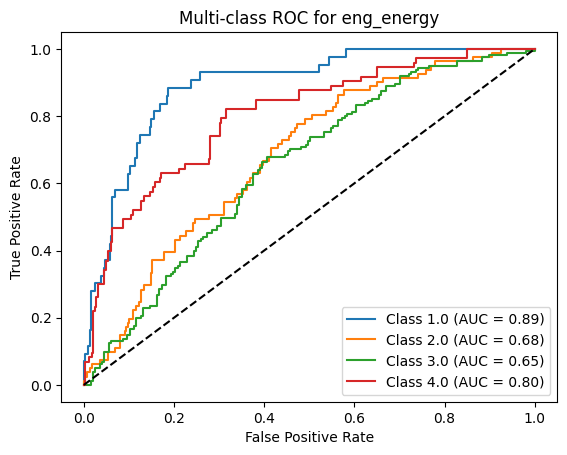

In [10]:
unique_classes = np.unique(Xgboost.y_test)

for dimension in ['eng_timeflies', 'eng_enthusiastic', 'eng_energy']:
    probas = Results_XGB_Proba_dict[dimension][-1]

    # Binarize the output
    from sklearn.preprocessing import label_binarize
    y_bin = label_binarize(y_test, classes=np.unique(Xgboost.y_test))
    
    n_classes = y_bin.shape[1]

   # Compute ROC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probas[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure()
    for i, class_value in enumerate(unique_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {class_value} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multi-class ROC for {dimension}')
    plt.legend(loc="lower right")
    plt.show()